In [ ]:
import tensorflow.keras.backend as K
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Lambda
import pickle

def make_pairs(images, labels):
	# initialize two empty lists to hold the (image, image) pairs and
	# labels to indicate if a pair is positive or negative
  pairImages = []
  pairLabels = []
	# calculate the total number of classes present in the dataset
	# and then build a list of indexes for each class label that
	# provides the indexes for all examples with a given label
  Classes = list(np.unique(labels))
  #labs = list(np.unique(labels))
  idx = {}# provides the indexes for all examples with a given label
  
  for i in Classes:
    idx[i] = np.array(np.where(labels==i)[0])

	# loop over all images
  for idxA in range(len(images)):
    # grab the current image and label belonging to the current
    # iteration
    currentImage = images[idxA]
    label = labels[idxA]
    # randomly pick an image that belongs to the *same* class
    # label
  
    idxB = np.random.choice(idx[label])
    posImage = images[idxB]
		# prepare a positive pair and update the images and labels
		# lists, respectively
    pairImages.append([currentImage, posImage])
    pairLabels.append([1])
		# grab the indices for each of the class labels *not* equal to
		# the current label and randomly pick an image corresponding
		# to a label *not* equal to the current label
    negIdx = np.where(labels != label)[0]
    negImage = images[np.random.choice(negIdx)]
		# prepare a negative pair of images and update our lists
    pairImages.append([currentImage, negImage])
    pairLabels.append([0])
	# return a 2-tuple of our image pairs and labels
  return (np.array(pairImages), np.array(pairLabels))

def euclidean_dist(vectors):
	# unpack the vectors into separate lists
	(featsA, featsB) = vectors
	# compute the sum of squared distances between the vectors
	sumSquared = K.sum(K.square(featsA - featsB), axis=1,keepdims=True)
	# return the euclidean distance between the vectors
	return K.sqrt(K.maximum(sumSquared, K.epsilon()))
 
def plot_training_loss(H):
	# construct a plot that plots and saves the training history
	plt.style.use("ggplot")
	plt.figure()
	plt.plot(H.history["loss"], label="train_loss")
	plt.plot(H.history["val_loss"], label="val_loss")
	plt.title("Training Loss")
	plt.xlabel("Epoch #")
	plt.ylabel("Loss")
	plt.legend(loc="lower left")
	#plt.savefig(plotPath)
 

def build_siamese_model(inputShape, embeddingDim=448):
	# specify the inputs for the feature extractor network
	inputs = Input(inputShape)
	# define the first set of CONV => RELU => POOL => DROPOUT layers
	x = Conv2D(64, (2, 2), padding="same", activation="relu")(inputs)
	x = MaxPooling2D(pool_size=(2, 2))(x)
	x = Dropout(0.3)(x)
	# second set of CONV => RELU => POOL => DROPOUT layers
	x = Conv2D(64, (2, 2), padding="same", activation="relu")(x)
	x = MaxPooling2D(pool_size=2)(x)
	x = Dropout(0.3)(x)
	# prepare the final outputs
	pooledOutput = GlobalAveragePooling2D()(x)
	outputs = Dense(embeddingDim)(pooledOutput)
	# build the model
	model = Model(inputs, outputs)
	# return the model to the calling function
	return model

def contrastive_loss(y, preds, margin=1):
	# explicitly cast the true class label data type to the predicted
	# class label data type (otherwise we run the risk of having two
	# separate data types, causing TensorFlow to error out)
	y = tf.cast(y, preds.dtype)
	# calculate the contrastive loss between the true labels and
	# the predicted labels
	squaredPreds = K.square(preds)
	squaredMargin = K.square(K.maximum(margin - preds, 0))
	loss = K.mean(y * squaredPreds + (1 - y) * squaredMargin)
	# return the computed contrastive loss to the calling function
	return loss


In [ ]:
from tensorflow.keras.preprocessing import image
import csv
import random
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

train_imgs = []
with open('/content/drive/MyDrive/ML_PROJECT/Mid_Data/train.csv', 'r') as file:
  reader = csv.reader(file)
  for row in reader:
    train_imgs.append(row)
random.shuffle(train_imgs)

In [ ]:
print(len(train_imgs))

8537


In [ ]:
# from google.colab.patches import cv2_imshow
# import cv2
# datapath='/content/drive/MyDrive/ML_PROJECT/Mid_Data'
# train_X = []
# train_y = []
# for ind in range(1000):
#   impath = datapath+"/train/"+train_imgs[ind][0]
 
#   im = image.load_img(impath, target_size=(224, 224))
#   x = image.img_to_array(im)
#   x = x/255
#   train_X.append(x)
#   train_y.append(train_imgs[ind][1])
#   if(len(train_X)%100==0):
#     print(len(train_y), end=" ")

# import pickle
# pickle.dump((train_X, train_y), open( "/content/drive/MyDrive/ML_PROJECT/midtraindata.txt", "wb" ) )

In [ ]:
train_X, train_y = pickle.load(open("/content/drive/MyDrive/ML_PROJECT/midtraindata.txt", "rb"))

In [ ]:
trainX = np.array(train_X[:500])
trainY = np.array(train_y[:500])
testX = np.array(train_X[500:600])
testY = np.array(train_y[500:600])

In [ ]:
# prepare the positive and negative pairs
print("[INFO] preparing positive and negative pairs...")
(pairTrain, labelTrain) = make_pairs(trainX, trainY)
(pairTest, labelTest) = make_pairs(testX, testY)
pickle.dump((pairTrain, labelTrain), open( "/content/drive/MyDrive/ML_PROJECT/trainpairs2.txt", "wb" ) )
pickle.dump((pairTest, labelTest), open( "/content/drive/MyDrive/ML_PROJECT/valpairs2.txt", "wb" ) )

[INFO] preparing positive and negative pairs...


[INFO] building siamese network...
[INFO] compiling model...
[INFO] training model...
Epoch 1/20
50/50 [==============================] - 157s 3s/step - loss: 0.3095 - accuracy: 0.4938 - val_loss: 0.2857 - val_accuracy: 0.4550
Epoch 2/20
50/50 [==============================] - 155s 3s/step - loss: 0.2883 - accuracy: 0.4785 - val_loss: 0.2852 - val_accuracy: 0.4500
Epoch 3/20
50/50 [==============================] - 154s 3s/step - loss: 0.2803 - accuracy: 0.4622 - val_loss: 0.2870 - val_accuracy: 0.4900
Epoch 4/20
50/50 [==============================] - 154s 3s/step - loss: 0.2835 - accuracy: 0.4794 - val_loss: 0.2853 - val_accuracy: 0.4700
Epoch 5/20
50/50 [==============================] - 154s 3s/step - loss: 0.2828 - accuracy: 0.4633 - val_loss: 0.2803 - val_accuracy: 0.4600
Epoch 6/20
50/50 [==============================] - 154s 3s/step - loss: 0.2700 - accuracy: 0.4509 - val_loss: 0.2858 - val_accuracy: 0.5000
Epoch 7/20
50/50 [==============================] - 153s 3s/step - l

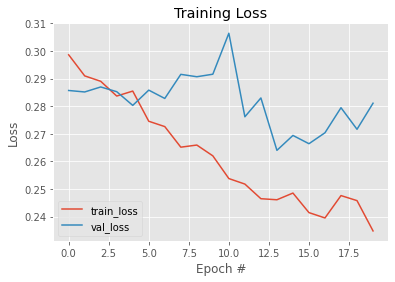

In [ ]:
IMG_SHAPE = (224,224,3)
BATCH_SIZE = 20
EPOCHS = 20
MODEL_PATH = "/content/drive/MyDrive/ML_PROJECT/siamese_model2"

# configure the siamese network
print("[INFO] building siamese network...")
imgA = Input(shape=IMG_SHAPE)
imgB = Input(shape=IMG_SHAPE)
featureExtractor = build_siamese_model(IMG_SHAPE)
featsA = featureExtractor(imgA)
featsB = featureExtractor(imgB)
# finally, construct the siamese network
distance = Lambda(euclidean_dist)([featsA, featsB])
model = Model(inputs=[imgA, imgB], outputs=distance)

# compile the model
print("[INFO] compiling model...")
model.compile(loss=contrastive_loss, optimizer="adam", metrics=["accuracy"])
# train the model
print("[INFO] training model...")
history = model.fit([pairTrain[:, 0], pairTrain[:, 1]], labelTrain[:],
                    validation_data=([pairTest[:, 0], pairTest[:, 1]], labelTest[:]),
                    batch_size=BATCH_SIZE, epochs=EPOCHS)
# serialize the model to disk
print("[INFO] saving siamese model...")
model.save(MODEL_PATH)
# plot the training history
print("[INFO] plotting training history...")
plot_training_loss(history)

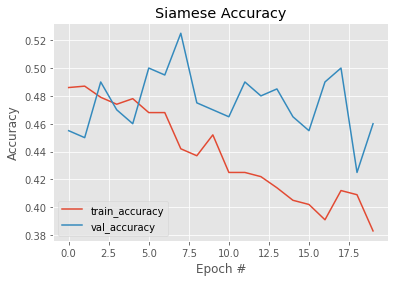

In [ ]:
def plot_training(H):
	# construct a plot that plots and saves the training history
	plt.style.use("ggplot")
	plt.figure()
	plt.plot(H.history["accuracy"], label="train_accuracy")
	plt.plot(H.history["val_accuracy"], label="val_accuracy")
	plt.title("Siamese Accuracy")
	plt.xlabel("Epoch #")
	plt.ylabel("Accuracy")
	plt.legend(loc="lower left")
	#plt.savefig(plotPath)

plot_training(history)

In [ ]:
from tensorflow.keras.models import load_model
MODEL_PATH = "/content/drive/MyDrive/ML_PROJECT/siamese_model2"
print("[INFO] loading siamese model...")
model = load_model(MODEL_PATH, compile=False)

[INFO] loading siamese model...


In [ ]:
plot_training_loss(history)

In [ ]:
test_imgs = []
with open('/content/drive/MyDrive/ML_PROJECT/Mid_Data/test.csv', 'r') as file:
  reader = csv.reader(file)
  for row in reader:
    test_imgs.append(row)
random.shuffle(test_imgs)

In [ ]:
datapath='/content/drive/MyDrive/ML_PROJECT/Mid_Data'
test_X = []
test_y = []
for ind in range(500):
  impath = datapath+"/test/"+test_imgs[ind][0]
 
  im = image.load_img(impath, target_size=(224, 224))
  x = image.img_to_array(im)
  x = x/255
  test_X.append(x)
  test_y.append(test_imgs[ind][1])
  if(len(test_X)%100==0):
    print(len(test_y), end=" ")

100 200 300 400 500 

In [ ]:
import pickle
pickle.dump((test_X, test_y), open( "/content/drive/MyDrive/ML_PROJECT/midtestdata.txt", "wb" ) )

In [ ]:
test_X, test_y = pickle.load(open("/content/drive/MyDrive/ML_PROJECT/midtestdata.txt", "rb"))

In [ ]:
testX = np.array(test_X[:200])
testy = np.array(test_y[:200])

In [ ]:
from skimage.measure import compare_ssim
import cv2

In [ ]:
def retrieve_images(test_img, test_img_lbl):
  test_pairs = []
  for i in range(400):
    if trainY[i]==test_img_lbl:
      test_pairs.append([test_img, trainX[i]])

  fig = plt.figure("Test Image:", figsize = (2,2))
  plt.suptitle("Test Image:")
  plt.imshow(test_img)
  plt.axis("off")
  plt.show()

  dists = []
  for ind in range(len(test_pairs)):
    i = test_pairs[ind]
    preds = model.predict([np.array([i[0]]), np.array([i[1]])])
    proba = preds[0][0]
    dists.append(proba)
    
  # print("Top 10 similar images")
  dists = np.array(dists)
  inds = np.argsort(dists)[:10]
  SSIM = 0
  for i in inds:
    im = test_pairs[i][1]
    grayA = cv2.cvtColor(test_img, cv2.COLOR_RGB2GRAY)
    grayB = cv2.cvtColor(im, cv2.COLOR_RGB2GRAY)
    (score, diff) = compare_ssim(grayA, grayB, full=True)
    SSIM += score
    fig = plt.figure("Retrieved Images:", figsize = (2,2))
    plt.suptitle("Distance:"+str(dists[i]))
    plt.imshow(im)
    plt.axis("off")
    plt.show()
  SSIM = SSIM/10
  print("Average SSIM score:", SSIM)
  return SSIM


In [ ]:
test_img = testX[197]
test_img_lbl = testy[197]

retrieve_images(test_img, test_img_lbl)

In [ ]:
av_ssim = 0 
for i in range(200):
  print(i, end=" ")
  test_img = testX[i]
  test_img_lbl = testy[i]
  av_ssim += retrieve_images(test_img, test_img_lbl)
av_ssim = av_ssim/200

print("Average SSIM score for test images:", av_ssim)

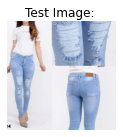

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:41: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.


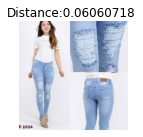

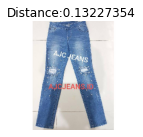

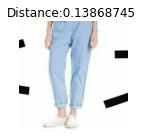

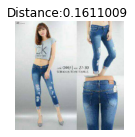

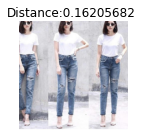

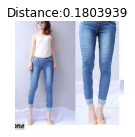

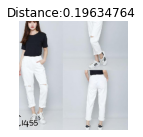

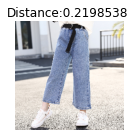

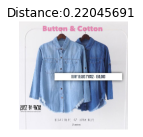

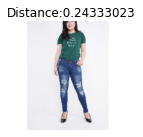

Average SSIM score: 0.4770715568259427


0.4770715568259427

In [ ]:
test_img = testX[104]
test_img_lbl = testy[104]

retrieve_images(test_img, test_img_lbl)

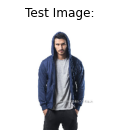

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:41: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.


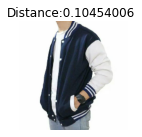

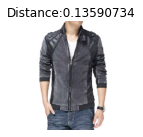

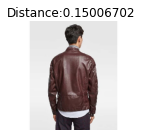

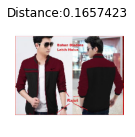

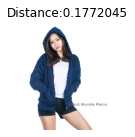

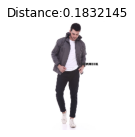

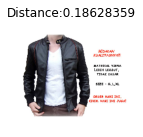

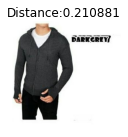

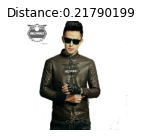

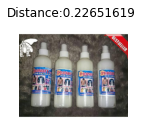

Average SSIM score: 0.5341053072382931


0.5341053072382931

In [ ]:
test_img = testX[110]
test_img_lbl = testy[110]

retrieve_images(test_img, test_img_lbl)

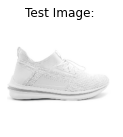

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:41: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.


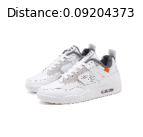

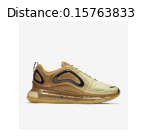

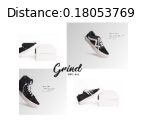

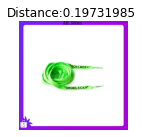

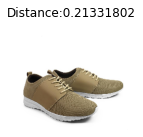

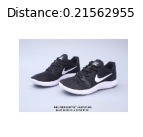

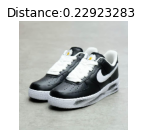

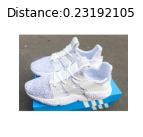

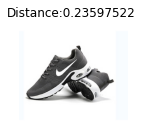

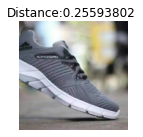

Average SSIM score: 0.6521740986619303


0.6521740986619303

In [ ]:
test_img = testX[138]
test_img_lbl = testy[138]

retrieve_images(test_img, test_img_lbl)

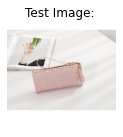

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:41: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.


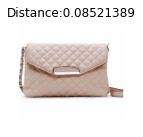

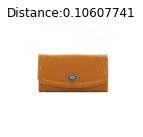

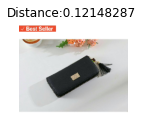

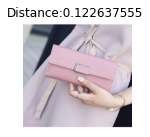

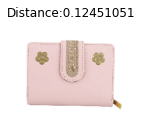

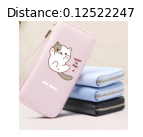

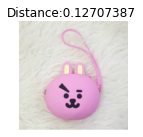

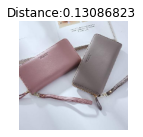

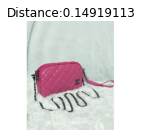

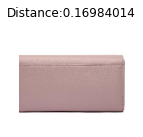

Average SSIM score: 0.6874020925349975


0.6874020925349975

In [ ]:
test_img = testX[136]
test_img_lbl = testy[136]

retrieve_images(test_img, test_img_lbl)

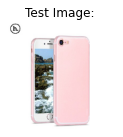

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:41: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.


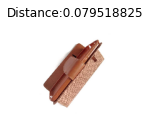

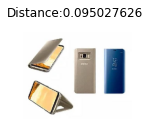

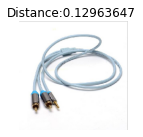

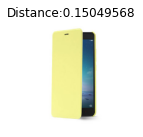

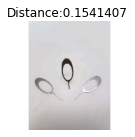

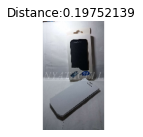

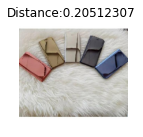

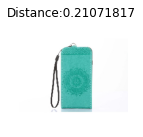

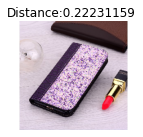

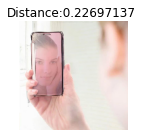

Average SSIM score: 0.6220206645026892


0.6220206645026892

In [ ]:
test_img = testX[186]
test_img_lbl = testy[186]

retrieve_images(test_img, test_img_lbl)

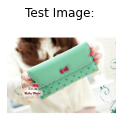

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:41: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.


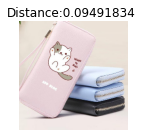

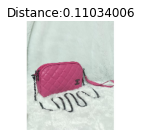

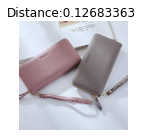

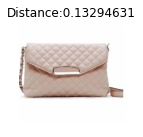

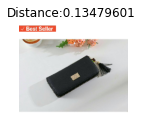

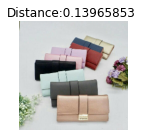

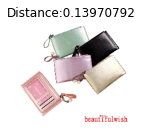

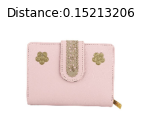

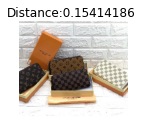

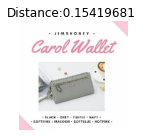

Average SSIM score: 0.5426452704575928


0.5426452704575928

In [ ]:
test_img = testX[167]
test_img_lbl = testy[167]

retrieve_images(test_img, test_img_lbl)

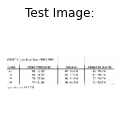

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:41: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.


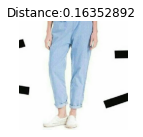

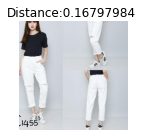

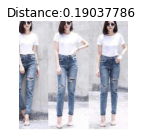

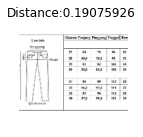

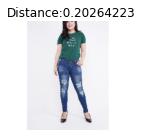

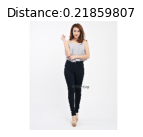

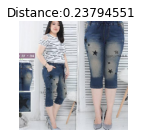

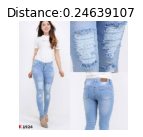

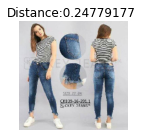

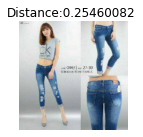

Average SSIM score: 0.5647859225140011


0.5647859225140011

In [ ]:
test_img = testX[137]
test_img_lbl = testy[137]

retrieve_images(test_img, test_img_lbl)

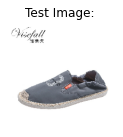

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:41: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.


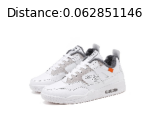

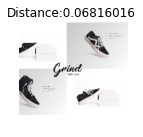

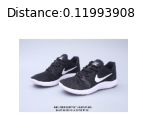

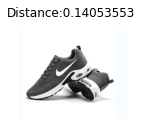

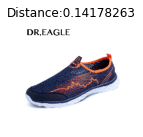

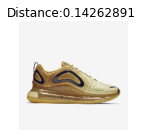

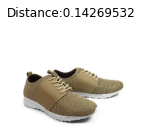

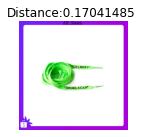

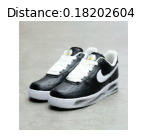

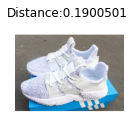

Average SSIM score: 0.628861189080843


0.628861189080843

In [ ]:
test_img = testX[44]
test_img_lbl = testy[44]

retrieve_images(test_img, test_img_lbl)

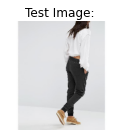

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:41: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.


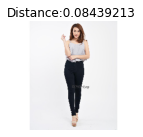

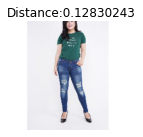

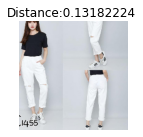

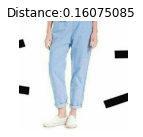

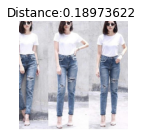

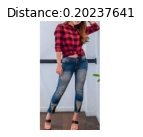

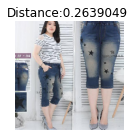

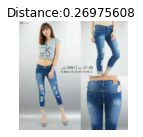

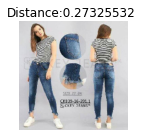

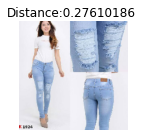

Average SSIM score: 0.5725758553414526


0.5725758553414526

In [ ]:
test_img = testX[1]
test_img_lbl = testy[1]

retrieve_images(test_img, test_img_lbl)